In [27]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
"""
wanted to try out bokeh,
thanks to Tom Bresee for his EDA that was helpful in figuring this out
https://www.kaggle.com/tombresee/next-gen-eda
"""
from bokeh.io import show
from bokeh.io import push_notebook
from bokeh.io import output_notebook
from bokeh.io import output_file
from bokeh.io import curdoc
from bokeh.io import export_png
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from bokeh.plotting import show                  
from bokeh.plotting import figure                  
from bokeh.plotting import output_notebook 
from bokeh.plotting import output_file
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from bokeh.models import ColumnDataSource, LabelSet, Label
from bokeh.models import Grid 
from bokeh.models import Plot
# from bokeh.models import FactorRange
from bokeh.models import Title
from bokeh.models.tools import HoverTool
from bokeh.models.glyphs import HBar
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from bokeh.core.properties import value
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from bokeh.layouts import row
from bokeh.layouts import column
from bokeh.layouts import gridplot
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from bokeh.transform import factor_cmap
from bokeh.palettes import cividis


import warnings
warnings.filterwarnings('ignore')

In [2]:
# url_2018 = "https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_2018.csv"
url_2019 = "https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_2019.csv"

# _2018 = pd.read_csv(url_2018)
_2019 = pd.read_csv(url_2019)

In [3]:
"""
stack the data so we have one df
delete other dfs to save on memory 
"""
# df = pd.concat([_2018, _2019], ignore_index=True)
# del _2018
# del _2019
df = _2019
recent_date = max(pd.to_datetime(df['game_date'])).strftime("%m-%d-%Y")

In [4]:
"""
goal is to filter to only dropbacks
"""
def drop_rows(data, mask):
    data = data[mask]
    return data

mask = df['play_type'] == "pass"
df = drop_rows(df, mask)
# mask = pd.notnull(df['epa'])
# df = drop_rows(df, mask)

In [5]:
"""
printing each columns so we can look at what we need
"""
col_list = list(df.columns.values)
print(col_list)

['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob'

In [6]:
"""
creating our df for WRs. This is manual as I wanted to sift through 
and decide which columns I would like to use in my analysis
"""
wr_df = df[["receiver_player_id","receiver_player_name", "epa", "air_yards","pass_length",
            "pass_location","td_prob","total_home_epa", "total_away_epa","total_home_pass_epa",
            "total_away_pass_epa","yac_epa","air_epa","comp_air_epa","comp_yac_epa","home_wp",
            "away_wp", "wpa", 'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa',"incomplete_pass",
            "interception","pass_attempt","touchdown", "pass_touchdown", "complete_pass"]]
wr_df = wr_df.dropna(subset=["epa"])

In [7]:
# wr_df.pass_touchdown.value_counts()

I want to try and see if I can identify "clutch" WRs. To do this I will filter by toudchdown plays, filter by players with at least 5 touch downs, and then calculate Mean EPA and Mean Touchdown probability then plot them against each other 

In [8]:

mask = wr_df['touchdown'] == 1
tds = drop_rows(wr_df, mask)
#filltering by having more than 5 Tds
tds = tds[tds.groupby("receiver_player_name")['receiver_player_name'].transform('size') >= 5]
# tds.receiver_player_name.value_counts()

In [9]:
td_df = tds[["receiver_player_name","epa","touchdown","td_prob"]]
td_df = td_df.dropna(subset=['receiver_player_name'])
td_df.head(10)

,receiver_player_name,epa,touchdown,td_prob
411,T.McLaurin,6.040785,1.0,0.306364
564,C.Beasley,-6.608273,1.0,0.273371
708,J.Brown,4.839464,1.0,0.289189
739,A.Thielen,3.189541,1.0,0.448448
867,C.Ridley,4.687990,1.0,0.127457
918,M.Brown,3.800162,1.0,0.469660
929,M.Brown,7.746265,1.0,0.274359
1048,M.Andrews,3.797157,1.0,0.173751
1097,D.Chark,4.319623,1.0,0.351854
1407,J.Landry,-7.974306,1.0,0.220681


In [10]:
td_df = td_df.groupby('receiver_player_name').mean()
td_df = td_df.reset_index()

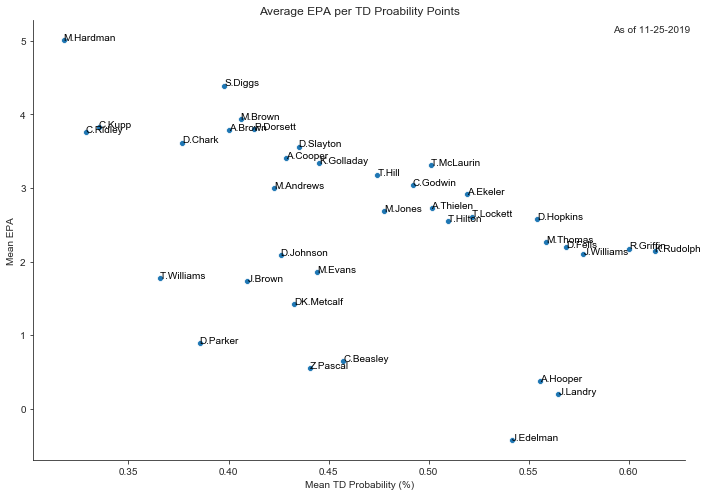

In [11]:
# sns.set_style("white", {'grid.linestyle': '--'})
sns.set_style("ticks", {'grid.linestyle': '--'})
##sns.set(style="white", palette="muted", color_codes=True)
# sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots(figsize=(10,7))

p1 = sns.scatterplot(x='td_prob',
                y='epa',
                data=td_df)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.title('Average EPA per TD Proability Points',
           fontsize=12, loc="center")
ax.set(ylabel="Mean EPA")
ax.set(xlabel="Mean TD Probability (%)")

for line in range(0,td_df.shape[0]):
     p1.text(td_df.td_prob[line], td_df.epa[line], 
             td_df.receiver_player_name[line], 
             horizontalalignment='left', size='medium', color='black')
        
ax.annotate("As of " + recent_date, xy=(1,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="right", va="top")

plt.tight_layout()
plt.show()

Higher and to the left signifies players who have more EPA on lower proability touchdowns or are more "clutch". I'm not sure how I feel about this measure so I'm going to take a look at WRs in a couple different ways

Let's check the Air Yards Leaders this Season

In [12]:
air = wr_df[["receiver_player_name","air_yards"]]
air = air.dropna(subset=['receiver_player_name'])
air = air.groupby('receiver_player_name').sum()
air = air.sort_values('air_yards', ascending=False)
air = air.reset_index()
air = air[:20]

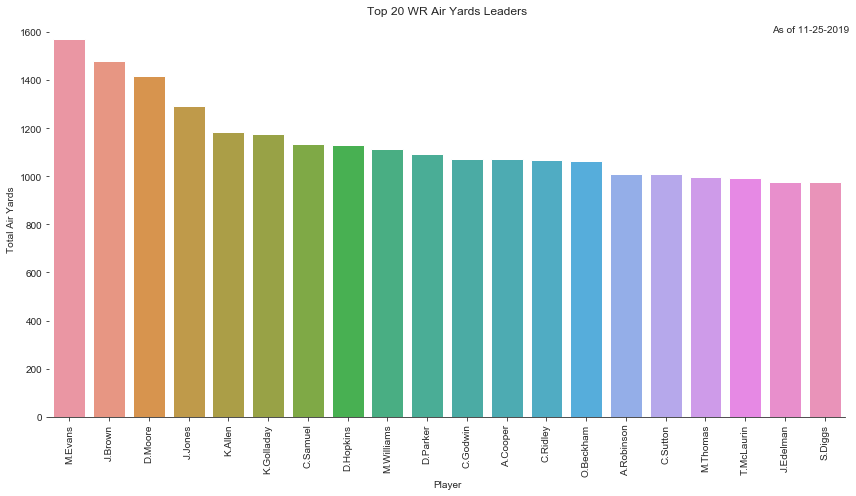

In [13]:
# sns.set_style("white", {'grid.linestyle': '--'})
sns.set_style("ticks", {'grid.linestyle': '--'})
##sns.set(style="white", palette="muted", color_codes=True)
# sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots(figsize=(12,7))

sns.barplot(x='receiver_player_name',
            y='air_yards',
            data=air)

sns.despine(top=True, right=True, left=True, bottom=False)

plt.title('Top 20 WR Air Yards Leaders',
           fontsize=12, loc="center")
ax.set(ylabel="Total Air Yards")
ax.set(xlabel="Player")

plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light')

# ax.text(16, -5, "As of 11-25-2019")

ax.annotate("As of " + recent_date, xy=(1,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="right", va="top")
# for line in range(0,td_df.shape[0]):
#      p1.text(td_df.td_prob[line], td_df.epa[line], 
#              td_df.receiver_player_name[line], 
#              horizontalalignment='left', size='medium', color='black')

plt.tight_layout()
plt.show()

While this is interesting, this doesn't tell me much. What is interesting is that Jarvis Landry appears on the EPA chart but not the air yards chart. I'll look into OBJ vs Landry later

In [14]:
comps = wr_df[["receiver_player_name","complete_pass"]]
comps = comps.dropna(subset=['receiver_player_name'])
comps_sum = comps.groupby('receiver_player_name').sum()
comps_sum = comps_sum.reset_index()
counts = pd.DataFrame(comps.receiver_player_name.value_counts())
counts = counts.reset_index()
counts = counts.rename(columns={"receiver_player_name":"total_passes",
                                "index":"receiver_player_name"})

comps = air.merge(comps_sum, how='inner', on="receiver_player_name")
comps = comps.merge(counts, how='inner', on='receiver_player_name')

In [15]:
comps['comp_pct'] = comps['complete_pass'] / comps['total_passes']

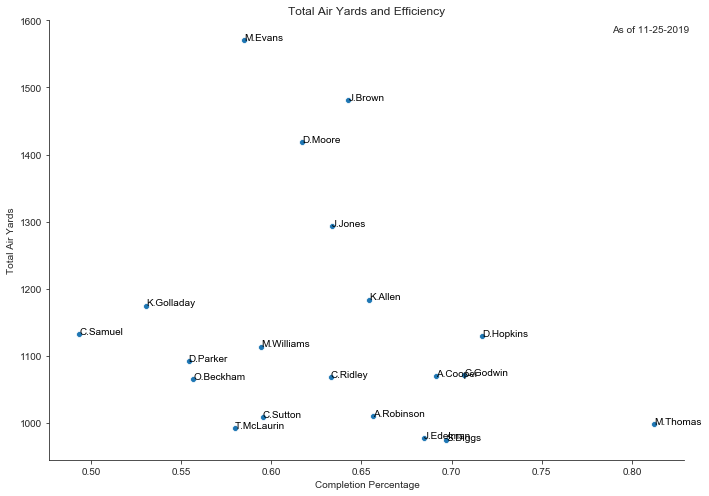

In [16]:
# sns.set_style("white", {'grid.linestyle': '--'})
sns.set_style("ticks", {'grid.linestyle': '--'})
##sns.set(style="white", palette="muted", color_codes=True)
# sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots(figsize=(10,7))

p1 = sns.scatterplot(x='comp_pct',
                     y='air_yards',
                     data=comps)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.title('Total Air Yards and Efficiency',
           fontsize=12, loc="center")
ax.set(ylabel="Total Air Yards")
ax.set(xlabel="Completion Percentage")

for line in range(0,comps.shape[0]):
     p1.text(comps.comp_pct[line], comps.air_yards[line], 
             comps.receiver_player_name[line], 
             horizontalalignment='left', size='medium', color='black')
        
ax.annotate("As of " + recent_date, xy=(1,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="right", va="top")

plt.tight_layout()
plt.show()

Not super telling...let's try looking at Air Yards Per Completion

In [17]:
comps['air_yards_pcmp'] = comps['air_yards'] / comps['complete_pass']

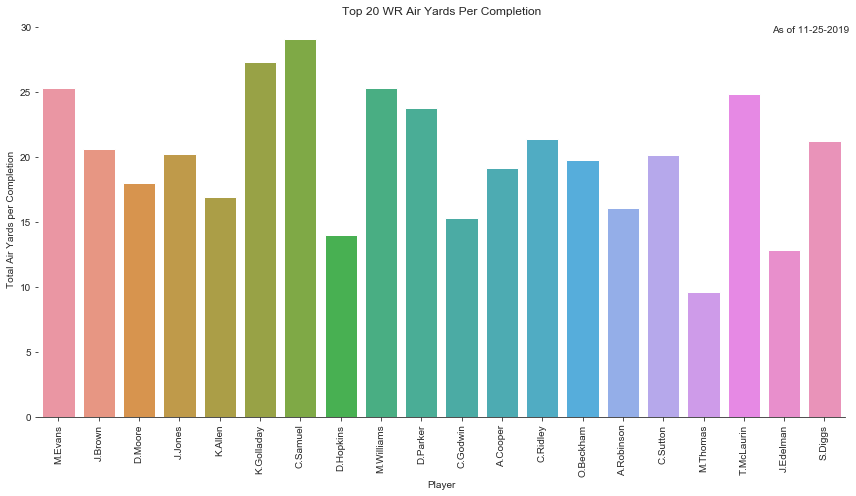

In [18]:
# sns.set_style("white", {'grid.linestyle': '--'})
sns.set_style("ticks", {'grid.linestyle': '--'})
##sns.set(style="white", palette="muted", color_codes=True)
# sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots(figsize=(12,7))

sns.barplot(x='receiver_player_name',
            y='air_yards_pcmp',
            data=comps)

sns.despine(top=True, right=True, left=True, bottom=False)

plt.title('Top 20 WR Air Yards Per Completion',
           fontsize=12, loc="center")
ax.set(ylabel="Total Air Yards per Completion")
ax.set(xlabel="Player")

plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light')


ax.annotate("As of " + recent_date, xy=(1,1), xycoords="axes fraction",
                    xytext=(5,-5), textcoords="offset points",
                    ha="right", va="top")


plt.tight_layout()
plt.show()

After taking a look at this, I don't feel like this tells us much, and I forgot to re-filter the list of players. 

We'll now take a look at Air Yards per Target and list out the top 32 players after filtering for 30 or more targets

In [19]:
def create_ay_df(df):
    air = df[["receiver_player_name","air_yards"]]
    air = air.dropna(subset=['receiver_player_name'])
    air = air.groupby('receiver_player_name').sum()
    air = air.sort_values('air_yards', ascending=False)
    air = air.reset_index()
    comps = wr_df[["receiver_player_name","complete_pass"]]
    comps = comps.dropna(subset=['receiver_player_name'])
    comps_sum = comps.groupby('receiver_player_name').sum()
    comps_sum = comps_sum.reset_index()
    counts = pd.DataFrame(comps.receiver_player_name.value_counts())
    counts = counts.reset_index()
    counts = counts.rename(columns={"receiver_player_name":"total_passes",
                                    "index":"receiver_player_name"})
    comps = air.merge(comps_sum, how='inner', on="receiver_player_name")
    comps = comps.merge(counts, how='inner', on='receiver_player_name')
    comps['ay_target'] = comps['air_yards'] / comps['total_passes']

    mask = comps['total_passes'] >= 50
    comps = drop_rows(comps, mask)

    comps = comps.sort_values("ay_target", ascending=False)
    total_df = comps
    comps_short = comps[:32]
    comps_qk = comps[-20:]
    comps = comps[:20]
    return comps, comps_qk, comps_short, total_df

comps, comps_qk, comps_short, total_df = create_ay_df(wr_df)
    

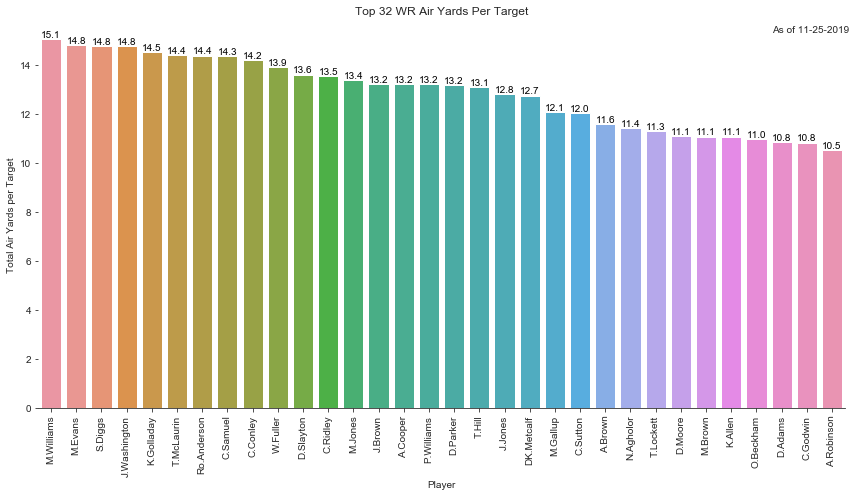

In [20]:
sns.set_style("ticks", {'grid.linestyle': '--'})

fig, ax = plt.subplots(figsize=(12,7))

sns.barplot(x='receiver_player_name',
            y='ay_target',
            data=comps_short)

sns.despine(top=True, right=True, left=True, bottom=False)

plt.title('Top 32 WR Air Yards Per Target', 
          fontsize=12, loc="center")
ax.set(ylabel="Total Air Yards per Target")
ax.set(xlabel="Player")
            
plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light')
            
ax.annotate("As of " + recent_date, xy=(1,1), xycoords="axes fraction",
             xytext=(5,-5), textcoords="offset points",
             ha="right", va="top")

for i, v in enumerate(comps_short["ay_target"].iteritems()):        
    ax.text(i ,v[1], "{:,.1f}".format(v[1]), color='black', va ='bottom', rotation=0, ha='center')

plt.tight_layout()
plt.show()

In [21]:
hover = HoverTool()
mysource = ColumnDataSource(comps)

p = figure(
  y_range=comps.receiver_player_name,
  title = '20 Players Targeted at the Longest Depth',
  x_axis_label ='Air Yards Per Target\n',
  plot_width=600,
  plot_height=700,
  tools="hover",
  toolbar_location=None,
  min_border=0
)

p.hbar(
    y='receiver_player_name',
    left=0,
    right='ay_target', 
    height=0.8,
    alpha=.6,
    fill_color=factor_cmap(
        'receiver_player_name',
        palette=cividis(20), #grey(50), #inferno(50),  #cividis(50),  #d3['Category20b'][4],  #Category20b(2),  #[2],   #Category20b,   #Viridis256,    #GnBu[8], #,#Spectral6,             #viridis(50),  #[3], #Spectral6,  #|Blues[2],
        factors=comps.receiver_player_name.tolist()
    ),

    source = mysource,
    fill_alpha=0.9,
#     line_color='blue'  
) 

# X-TICKS:
# p.xaxis[0].ticker = FixedTicker(ticks=[0, 1])
# p.xaxis.major_tick_line_color = GRID_COLOR
# p.xaxis.major_label_text_font_size = '7pt'
# p.xaxis.major_label_text_font = TEXT_FONT
# p.xaxis.major_label_text_color = None   #TEXT_COLOR
#
# Y-TICKS:
# p.yaxis.major_label_text_font_size = '0pt'
p.yaxis.major_tick_line_color = "Black"
p.axis.minor_tick_line_color = None  # turn off y-axis minor ticks

# p.xaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
# p.yaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
p.yaxis.major_tick_line_color = "Black"  # turn off y-axis major ticks
p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
# GRID:
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None   

hover.tooltips = [
    ("Player", "@receiver_player_name"),
    ("Air Yards per Target:", "@ay_target"),
    ("Number of Targets:", "@total_passes")
]
p.add_tools(hover)

mysource.data['formatted_ay'] = ["%.1f" % x for x in mysource.data['ay_target']]
# p.add_layout(Title(text="As of " + recent_date, align="right"), "below")
# p.add_layout(Title(text="Data from nflscrapR", align="right"), "below")

labels = LabelSet(x='ay_target', y='receiver_player_name', text='formatted_ay', 
                  text_font_size='7pt', level='glyph',
                  x_offset=0.5, y_offset=-4.5, source=mysource, render_mode='canvas')

citation = Label(x=320, y=640, x_units='screen', y_units='screen',
                 text='Data from nflscrapR as of ' + recent_date, 
                 text_font_size="7pt", text_align="left",
                 render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0)

signature = Label(x=480, y=-40, x_units='screen', y_units='screen',
                 text='@aramkaplanian', text_font_size="7pt", text_align="right",
                 render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0)

p.add_layout(labels)
p.add_layout(citation)
p.add_layout(signature)

output_notebook(hide_banner=True)
export_png(p, filename="20_deep_depth_"+recent_date+".png")
show(p)

In [22]:
mysource = ColumnDataSource(comps_qk)

p = figure(
  y_range=comps_qk.receiver_player_name,
  title = '20 Players Targeted the Shortest Depth',
  x_axis_label ='Air Yards Per Target\n',
  plot_width=600,
  plot_height=700,
  tools="hover",
  toolbar_location=None,
  min_border=0
)

p.hbar(
    y='receiver_player_name',
    left=0,
    right='ay_target', 
    height=0.8,
    alpha=.6,
    fill_color=factor_cmap(
        'receiver_player_name',
        palette=cividis(20), #grey(50), #inferno(50),  #cividis(50),  #d3['Category20b'][4],  #Category20b(2),  #[2],   #Category20b,   #Viridis256,    #GnBu[8], #,#Spectral6,             #viridis(50),  #[3], #Spectral6,  #|Blues[2],
        factors=comps_qk.receiver_player_name.tolist()
    ),

    source = mysource,
    fill_alpha=0.9,
#     line_color='blue'  
) 

# X-TICKS:
# p.xaxis[0].ticker = FixedTicker(ticks=[0, 1])
# p.xaxis.major_tick_line_color = GRID_COLOR
# p.xaxis.major_label_text_font_size = '7pt'
# p.xaxis.major_label_text_font = TEXT_FONT
# p.xaxis.major_label_text_color = None   #TEXT_COLOR
#
# Y-TICKS:
# p.yaxis.major_label_text_font_size = '0pt'
p.yaxis.major_tick_line_color = "Black"
p.axis.minor_tick_line_color = None  # turn off y-axis minor ticks

# p.xaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
# p.yaxis.major_label_text_font_size = '0pt'  # preferred method for removing tick labels
p.yaxis.major_tick_line_color = "Black"  # turn off y-axis major ticks
p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
# GRID:
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None   

hover.tooltips = [
    ("Player", "@receiver_player_name"),
    ("Air Yards per Target:", "@ay_target"),
    ("Number of Targets:", "@total_passes")
]
p.add_tools(hover)

mysource.data['formatted_ay'] = ["%.1f" % x for x in mysource.data['ay_target']]
# p.add_layout(Title(text="As of " + recent_date, align="right"), "below")
# p.add_layout(Title(text="Data from nflscrapR", align="right"), "below")

labels = LabelSet(x='ay_target', y='receiver_player_name', text='formatted_ay', 
                  text_font_size='7pt', level='glyph',
                  x_offset=0.5, y_offset=-4.5, source=mysource, render_mode='canvas')

citation = Label(x=320, y=640, x_units='screen', y_units='screen',
                 text='Data from nflscrapR as of ' + recent_date, 
                 text_font_size="7pt", text_align="left",
                 render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0)

signature = Label(x=480, y=-40, x_units='screen', y_units='screen',
                 text='@aramkaplanian', text_font_size="7pt", text_align="right",
                 render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0)

p.add_layout(labels)
p.add_layout(citation)
p.add_layout(signature)

output_notebook(hide_banner=True)
export_png(p, filename="20_short_depth_"+recent_date+".png")
show(p)

Okay, so now that we have some target depths I had an idea. We will now take a look at the players who catch balls between 5-10 yards vs players who are targeted at greater than 10 yards. 5 yards because it is considered a successful play, and 10 because it isn;t a very long pass that can potentially be safer than a 15 yard pass and serve the same goal of moving the chains.

In [47]:
# we already called have the data so we will just filter it
def croe_prep(df, mask, col_list):
    df = drop_rows(df, mask)
    df = df.reset_index(drop=True)
    df = df[col_list]
    df['target_grp'] = np.nan
    
    lngth = len(df)
    for i in range(0, lngth):
        if df.iloc[i,2] >= 100:
            df.iloc[i,3] = 100
        else:
            df.iloc[i,3] = round(df.iloc[i,2], -1)
    return df

def croe_calc(df, passes, targets):
    ce = df.drop(df.columns[0], axis=1)
    ce = ce.groupby('target_grp').sum()
    ce['exp'] = ce[passes] / ce[targets] 
    ce = ce.reset_index()
    ce = ce.drop([passes, targets], axis=1)
    df = df.merge(ce, how='left', on='target_grp')
    df['cr'] = df[passes] / df[targets]
    df['croe'] = df['cr'] - df['exp']
    return df 

col_list = ["receiver_player_name", "complete_pass", "total_passes"]

mask = total_df['ay_target'] > 10
deep_df = croe_prep(total_df, mask, col_list)

mask = (total_df['ay_target'] >= 5) & (total_df['ay_target'] <= 10)
short_df = croe_prep(total_df, mask, col_list)

short_df = croe_calc(short_df, "complete_pass", "total_passes")
deep_df = croe_calc(deep_df, "complete_pass", "total_passes")

In [45]:
deep_df

,receiver_player_name,complete_pass,total_passes,target_grp,exp,cr,croe
0,M.Williams,44.0,74,70.0,0.607504,0.594595,-0.012909
1,M.Evans,62.0,106,100.0,0.631206,0.584906,-0.046300
2,S.Diggs,46.0,66,70.0,0.607504,0.696970,0.089466
3,J.Washington,26.0,50,50.0,0.559211,0.520000,-0.039211
4,K.Golladay,43.0,81,80.0,0.614159,0.530864,-0.083295
5,T.McLaurin,40.0,69,70.0,0.607504,0.579710,-0.027793
6,Ro.Anderson,28.0,56,60.0,0.600973,0.500000,-0.100973
7,C.Samuel,39.0,79,80.0,0.614159,0.493671,-0.120488
8,C.Conley,33.0,66,70.0,0.607504,0.500000,-0.107504
9,W.Fuller,41.0,59,60.0,0.600973,0.694915,0.093942
